# grl model

# packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow or PyTorch?
import tensorflow as tf
from tensorflow import keras

import h5py
import scipy.io as sio
import time
from sklearn.metrics import roc_curve, auc

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[]

# data loading

In [3]:
# MNIST Dataset
(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = keras.datasets.mnist.load_data()

mnist_X_train.shape, mnist_y_train.shape, mnist_X_test.shape, mnist_y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
# USPS Dataset
with h5py.File('usps.h5', 'r') as hf:
    train = hf.get('train')
    usps_X_train = np.reshape(train.get('data')[:], (-1,16,16))
    usps_y_train = train.get('target')[:]
    test = hf.get('test')
    usps_X_test = np.reshape(test.get('data')[:], (-1,16,16))
    usps_y_test = test.get('target')[:]

usps_X_train.shape, usps_y_train.shape, usps_X_test.shape, usps_y_test.shape

((7291, 16, 16), (7291,), (2007, 16, 16), (2007,))

In [5]:
# SVHN Dataset
f = sio.loadmat('train_32x32.mat')
svhn_X_train = np.moveaxis(np.array(f['X']), -1, 0)
svhn_y_train = np.array(f['y']).squeeze()
f = sio.loadmat('test_32x32.mat')
svhn_X_test = np.moveaxis(np.array(f['X']), -1, 0)
svhn_y_test = np.array(f['y']).squeeze()

svhn_X_train.shape, svhn_y_train.shape, svhn_X_test.shape, svhn_y_test.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

In [6]:
svhn_y_train[svhn_y_train==10]=0
svhn_y_test[svhn_y_test==10]=0

# visualization

In [7]:
def plot_digits(X, y=None, grid=None, ax=None):
    if (X.ndim==2):
        if (ax is None):
            fig, ax = plt.subplots()
        ax.imshow(X, cmap='gray')
        ax.axis('off')
        if (y is not None):
            ax.set_title('Label ' + str(y))
        plt.show()
    else:
        if (ax is None):
            if (grid is None):
                fig, ax = plt.subplots(X.shape[0])
            else:
                fig, ax = plt.subplots(grid[0], grid[1])
        for i in range(X.shape[0]):
            ax.flatten()[i].imshow(X[i], cmap='gray')
            ax.flatten()[i].axis('off')
            if (y is not None):
                ax.flatten()[i].set_title('Label ' + str(y[i]))
        plt.show()
        
def plot_color_digits(X, y=None, grid=None, ax=None):
    if (X.ndim==3):
        if (ax is None):
            fig, ax = plt.subplots()
        ax.imshow(X)
        ax.axis('off')
        if (y is not None):
            ax.set_title('Label ' + str(y))
        plt.show()
    else:
        if (ax is None):
            if (grid is None):
                fig, ax = plt.subplots(X.shape[0])
            else:
                fig, ax = plt.subplots(grid[0], grid[1])
        for i in range(X.shape[0]):
            ax.flatten()[i].imshow(X[i])
            ax.flatten()[i].axis('off')
            if (y is not None):
                ax.flatten()[i].set_title('Label ' + str(y[i]))
        plt.show()

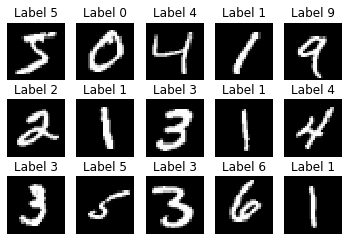

In [8]:
plot_digits(mnist_X_train[:15],mnist_y_train[:15],(3,5))

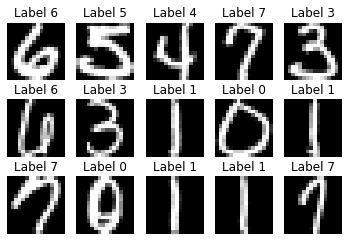

In [9]:
plot_digits(usps_X_train[:15],usps_y_train[:15],(3,5))

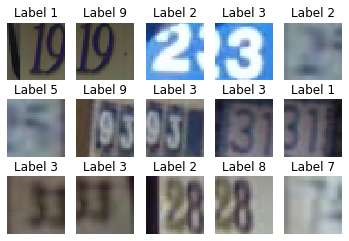

In [10]:
plot_color_digits(svhn_X_train[:15],svhn_y_train[:15],(3,5))

# data preprocessing

In [11]:
#training data
mnist_0_4 = np.nonzero(mnist_y_train < 5)[0]
mnist_5_9 = np.nonzero(mnist_y_train > 5)[0]
usps_0_4 = np.nonzero(usps_y_train < 5)[0]
usps_5_9 = np.nonzero(usps_y_train > 5)[0]
svhn_0_4 = np.nonzero(svhn_y_train < 5)[0]
svhn_5_9 = np.nonzero(svhn_y_train > 5)[0]

mnist_X_train = mnist_X_train[:, :, :, np.newaxis]
mnist_X_train = tf.broadcast_to(mnist_X_train, mnist_X_train.shape[:-1] + (3,))
mnist_X_train = tf.image.resize(mnist_X_train, (32,32))

usps_X_train = usps_X_train[:, :, :, np.newaxis]
usps_X_train = tf.broadcast_to(usps_X_train, usps_X_train.shape[:-1] + (3,))
usps_X_train = tf.image.resize(usps_X_train, (32,32))

svhn_X_train = tf.cast(tf.convert_to_tensor(svhn_X_train),'float32')

In [12]:
#testing data
mnist_0_4t = np.nonzero(mnist_y_test < 5)[0]
mnist_5_9t = np.nonzero(mnist_y_test > 5)[0]
usps_0_4t = np.nonzero(usps_y_test < 5)[0]
usps_5_9t = np.nonzero(usps_y_test > 5)[0]
svhn_0_4t = np.nonzero(svhn_y_test < 5)[0]
svhn_5_9t = np.nonzero(svhn_y_test > 5)[0]

mnist_X_test = mnist_X_test[:, :, :, np.newaxis]
mnist_X_test = tf.broadcast_to(mnist_X_test, mnist_X_test.shape[:-1] + (3,))
mnist_X_test = tf.image.resize(mnist_X_test, (32,32))

usps_X_test = usps_X_test[:, :, :, np.newaxis]
usps_X_test = tf.broadcast_to(usps_X_test, usps_X_test.shape[:-1] + (3,))
usps_X_test = tf.image.resize(usps_X_test, (32,32))

svhn_X_test = tf.cast(tf.convert_to_tensor(svhn_X_test),'float32')

# rescaling

In [13]:
#training
tf.math.reduce_min(mnist_X_train), tf.math.reduce_max(mnist_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=255.0>)

In [14]:
tf.math.reduce_min(usps_X_train), tf.math.reduce_max(usps_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [15]:
tf.math.reduce_min(svhn_X_train), tf.math.reduce_max(svhn_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=255.0>)

In [16]:
mnist_X_train = mnist_X_train / 255.0
svhn_X_train = svhn_X_train / 255.0
tf.math.reduce_min(mnist_X_train), tf.math.reduce_max(mnist_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [17]:
tf.math.reduce_min(svhn_X_train), tf.math.reduce_max(svhn_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [18]:
#testing
mnist_X_test = mnist_X_test / 255.0
svhn_X_test = svhn_X_test / 255.0

In [19]:
tf.math.reduce_min(mnist_X_test), tf.math.reduce_max(mnist_X_test)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [20]:
tf.math.reduce_min(svhn_X_test), tf.math.reduce_max(svhn_X_test)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

# normalization

In [21]:
mnist_train_mean = np.mean(mnist_X_train,)
mnist_train_std  = np.std(mnist_X_train)

In [22]:
mnist_train_mean, mnist_train_std

(0.13085152, 0.28923184)

In [23]:
usps_train_mean = np.mean(usps_X_train)
usps_train_std  = np.std(usps_X_train)

In [24]:
usps_train_mean, usps_train_std

(0.2544808, 0.3481659)

In [25]:
svhn_train_mean = np.mean(svhn_X_train)
svhn_train_std  = np.std(svhn_X_train)

In [26]:
svhn_train_mean, svhn_train_std

(0.45141736, 0.1992912)

# general model component

In [27]:
def FeatureEncoder(name=None):
    '''
    Return a Feature Encoder.
    '''
    fe_input = keras.Input(shape=(32,32,3))
    x = keras.layers.Dropout(0.2)(fe_input)
    x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    x = keras.layers.MaxPooling2D(2, strides=2)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    x = keras.layers.MaxPooling2D(2, strides=2)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    fe_out = keras.layers.Flatten()(x)
    if (name is None):
        fe = keras.Model(inputs=fe_input, outputs=fe_out, name='FeatureExtractor')
    else:
        fe = keras.Model(inputs=fe_input, outputs=fe_out, name=name)
    return fe

In [28]:
def ClassificationNet(name=None):
    '''
    Return a Classification Network.
    Input: None.
    Output: A tuple containing the handle of input layer and output layer.
    '''
    cl_input = keras.Input(shape=[128])
    x = keras.layers.Dense(128, activation='relu')(cl_input)
    cl_out = keras.layers.Dense(5, activation='relu')(x)
    if (name is None):
        cl = keras.Model(inputs=cl_input, outputs=cl_out, name='ClassificationNetwork')
    else:
        cl = keras.Model(inputs=cl_input, outputs=cl_out, name=name)
    return cl

# grl additional component

Flip Gradient Builder: The gradient reversal layer has no parameters as-sociated with it (apart from the meta-parameter λ, which is not updated by backpropagation). During the forward propagation, GRL acts as an identity transform. During the backpropagation though, GRL takes the gradient from the subsequent level, multiplies it by −λ and passes it to the preceding layer.

In [29]:
def flip_gradient(x, l=1.0):
    positive_path = tf.stop_gradient(x * tf.cast(1 + l, tf.float32))
    negative_path = -x * tf.cast(l, tf.float32)
    return positive_path + negative_path

# Domain prediction:

In [30]:
def DomainNet(name=None):
    '''
    Return a Domain Classification Network.
    Input: None.
    Output: A tuple containing the handle of input layer and output layer.
    '''
    dl_input = keras.Input(shape=[128])
    x = keras.layers.Dense(128, activation='relu')(dl_input)
    '''source/target, output shape = 2'''
    dl_out = keras.layers.Dense(2, activation='relu')(x)
    if (name is None):
        dl = keras.Model(inputs=dl_input, outputs=dl_out, name='DomainClassificationNetwork')
    else:
        dl = keras.Model(inputs=dl_input, outputs=dl_out, name=name)
    return dl

In [31]:
dl_demo = DomainNet()
dl_demo.summary()

Model: "DomainClassificationNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 16,770
Trainable params: 16,770
Non-trainable params: 0
_________________________________________________________________


# GRL model

Wiring up the component:

In [32]:
# Input layer
grl_input_src = keras.Input(shape=(32,32,3), name="SourceInput")
grl_input_tgt = keras.Input(shape=(32,32,3), name="TargetInput")
"no source input skip"

# Fed to the same feature extractor
grl_fe = FeatureEncoder()
grl_fe_src = grl_fe(grl_input_src)
grl_fe_tgt = grl_fe(grl_input_tgt)

# Source representation flows to the classification network
grl_out_cl = ClassificationNet()(grl_fe_src)

# Flip the gradient when backpropagating through this operation
grl_fe_src_feat = flip_gradient(grl_fe_src,1.0)#!!uncertain about self.l
grl_fe_tgt_feat = flip_gradient(grl_fe_tgt,1.0)

# Domain prediction
grl_dc = DomainNet()
grl_out_d_src = grl_dc(grl_fe_src_feat)
grl_out_d_tgt = grl_dc(grl_fe_tgt_feat)

# Final model
mod_grl = keras.Model(
    inputs=[grl_input_src, grl_input_tgt],
    outputs=[grl_out_cl,   # Categorical Classifier
             grl_out_d_src, # Sourve Domain Predictor
             grl_out_d_tgt] # Target Domain Preductor
)



In [33]:
mod_grl.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
SourceInput (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
TargetInput (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
FeatureExtractor (Functional)   (None, 128)          312256      SourceInput[0][0]                
                                                                 TargetInput[0][0]                
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, 128)          0           FeatureExtractor[0][0]       

# Build the model

In [34]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return tf.gather(X, idx), tf.gather(y, idx)

In [35]:
def print_status_bar(iteration, total, loss):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in loss])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

X_src = tf.gather(mnist_X_train, mnist_0_4)
y_src = tf.gather(mnist_y_train, mnist_0_4)
X_tgt = tf.gather(usps_X_train, usps_0_4)
y_tgt = tf.gather(usps_y_train, usps_0_4)
batch_size = 64
n_samples = max(len(X_src), len(X_tgt))
n_steps = n_samples // batch_size
src_size = batch_size
tgt_size = batch_size
X_src_batch, y_src_batch = random_batch(X_src, y_src, src_size)
X_tgt_batch, y_tgt_batch = random_batch(X_tgt, y_tgt, tgt_size)

outputs = mod_grl((X_src_batch, X_tgt_batch), training=True)
print(outputs[0])

In [36]:
def train_grl_model(model, X_src, y_src, X_tgt, y_tgt, optimizers, 
                    n_epochs=50,start_epoch=1,
                    batch_size=64, name=None):
    # Get the sample size, number of steps, source size, and target size
    
    n_samples = max(len(X_src), len(X_tgt))
    n_steps = n_samples // batch_size
    src_size = batch_size
    tgt_size = batch_size

    # Define loss functions
    layers = model.layers
    cat_loss = keras.losses.CategoricalCrossentropy()
    bin_loss = keras.losses.BinaryCrossentropy()
    
    
    # Define loss metrics and the history tracker
    loss_name = ['loss_ce','loss_domain','loss_f_total']
    mean_loss = []
    for l in loss_name:
        mean_loss.append(keras.metrics.Mean(name=l))
    history = [loss_name]
    
    for epoch in range(1, n_epochs + 1):
        print("Epoch {}/{}".format(epoch, n_epochs))
        
        for step in range(1, n_steps + 1):
            # Sample a batch from source and target data
            X_src_batch, y_src_batch = random_batch(X_src, y_src, src_size)
            X_tgt_batch, y_tgt_batch = random_batch(X_tgt, y_tgt, tgt_size)
            with tf.GradientTape(persistent=True) as tape:
                # Feed-forward Network
                outputs = model((X_src_batch, X_tgt_batch), training=True)
                # Separate the outputs
                out_c1 = outputs[0]
                d_src = outputs[1]
                d_tgt = outputs[2]
                #Calculate the losses
                loss_ce = cat_loss(tf.one_hot(y_src_batch,5), keras.activations.softmax(out_c1))
                loss_domain = (bin_loss(tf.constant([[1.]] * src_size), d_src) +
                               bin_loss(tf.constant([[1.]] * tgt_size), d_tgt))
                loss_f_total = loss_ce + loss_domain
                
            gradient_fe = tape.gradient(loss_f_total,
                                        model.get_layer('FeatureExtractor').trainable_variables)
            optimizers[0].apply_gradients(zip(gradient_fe,
                                              model.get_layer('FeatureExtractor').trainable_variables))
            gradient_ce = tape.gradient(loss_ce,
                                        model.get_layer('ClassificationNetwork').trainable_variables)
            optimizers[1].apply_gradients(zip(gradient_ce,
                                              model.get_layer('ClassificationNetwork').trainable_variables))
            gradient_domain = tape.gradient(loss_domain,
                                            model.get_layer('DomainClassificationNetwork').trainable_variables)
            optimizers[2].apply_gradients(zip(gradient_domain,
                                              model.get_layer('DomainClassificationNetwork').trainable_variables))
            
            mean_loss[0](loss_ce)
            mean_loss[1](loss_domain)
            mean_loss[2](loss_f_total)
            # Print Status Bar
            print_status_bar(step * batch_size, n_samples, mean_loss)

            # Save the history
            history.append([m.result() for m in mean_loss])
            
            # Delete the tape
            del(tape)

        # Refresh the status bar
        print_status_bar(n_samples, n_samples, mean_loss)
        
        # Save the model at this epoch
        model.save(name + '_epoch_' + str(epoch) + time.strftime("_%Y_%m_%d-%H_%M_%S"))
        
        # Reset the metrics
        for loss in mean_loss:
            loss.reset_states()

    return history

# train the model

In [37]:
opt = []
for i in range(3):
    opt.append(keras.optimizers.Nadam(learning_rate=0.0001))
history = train_grl_model(mod_grl, X_src = tf.gather(mnist_X_train, mnist_0_4),
                          y_src = tf.gather(mnist_y_train, mnist_0_4),
                          X_tgt = tf.gather(usps_X_train, usps_0_4),
                          y_tgt = tf.gather(usps_y_train, usps_0_4),
                          optimizers = opt, n_epochs = 5, batch_size=64, name='mnist_usps')

Epoch 1/5
30596/30596 - loss_ce: 0.8192 - loss_domain: 30.7982 - loss_f_total: 31.6175


INFO:tensorflow:Assets written to: mnist_usps_epoch_1_2020_11_30-21_37_34/assets


INFO:tensorflow:Assets written to: mnist_usps_epoch_1_2020_11_30-21_37_34/assets


Epoch 2/5
30596/30596 - loss_ce: 0.4533 - loss_domain: 30.8478 - loss_f_total: 31.3012


INFO:tensorflow:Assets written to: mnist_usps_epoch_2_2020_11_30-21_40_22/assets


INFO:tensorflow:Assets written to: mnist_usps_epoch_2_2020_11_30-21_40_22/assets


Epoch 3/5
30596/30596 - loss_ce: 0.4588 - loss_domain: 30.3504 - loss_f_total: 30.8093


INFO:tensorflow:Assets written to: mnist_usps_epoch_3_2020_11_30-21_43_10/assets


INFO:tensorflow:Assets written to: mnist_usps_epoch_3_2020_11_30-21_43_10/assets


Epoch 4/5
30596/30596 - loss_ce: 0.5511 - loss_domain: 7.3650 - loss_f_total: 7.916150


INFO:tensorflow:Assets written to: mnist_usps_epoch_4_2020_11_30-21_45_58/assets


INFO:tensorflow:Assets written to: mnist_usps_epoch_4_2020_11_30-21_45_58/assets


Epoch 5/5
30596/30596 - loss_ce: 0.1250 - loss_domain: 0.0000 - loss_f_total: 0.1250


INFO:tensorflow:Assets written to: mnist_usps_epoch_5_2020_11_30-21_48_47/assets


INFO:tensorflow:Assets written to: mnist_usps_epoch_5_2020_11_30-21_48_47/assets


In [38]:
history = np.array(history[1:])
history.shape

(2390, 3)

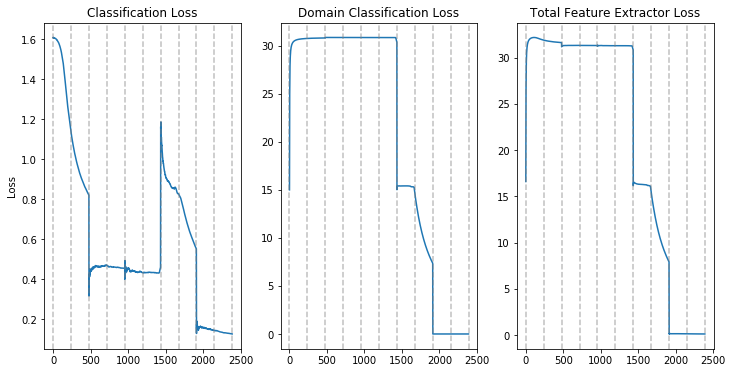

In [40]:
semantic_labels = ('Classification Loss', 'Domain Classification Loss','Total Feature Extractor Loss')
epoch_index = np.linspace(0,len(history),11)
fig, ax = plt.subplots(1,3,figsize=(12,6))
for i in range(3):
    ax.flatten()[i].plot(range(len(history)), history[:,i])
    ax.flatten()[i].set_title(semantic_labels[i])
    if (i>3):
        ax.flatten()[i].set_xlabel('# of Updates')
    if (i%4==0):
        ax.flatten()[i].set_ylabel('Loss')
    for j in range(len(epoch_index)):
        ax.flatten()[i].axvline(epoch_index[j], c='gray', ls='--', alpha=0.5)

Diagnostic Stats on Training Set

In [41]:
index = np.random.randint(0, min(len(mnist_0_4), len(usps_0_4)), 10)
X_src, X_tgt = (tf.gather(mnist_X_train, mnist_0_4[index]), 
                tf.gather(usps_X_train, usps_0_4[index]))
y_src, y_tgt = (tf.gather(mnist_y_train, mnist_0_4[index]),
                tf.gather(usps_y_train, usps_0_4[index]))
outputs = mod_grl((X_src, X_tgt))
(out_c1, d_src, d_tgt) = outputs
tf.nn.softmax(out_c1), tf.math.argmax(out_c1,axis=1), y_src

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[8.33883678e-06, 1.93577187e-04, 3.96374584e-04, 9.99398351e-01,
         3.37496385e-06],
        [6.00627791e-05, 1.95831596e-03, 6.65311655e-03, 9.91284609e-01,
         4.39314681e-05],
        [4.51810798e-03, 9.77548003e-01, 4.51810798e-03, 4.51810798e-03,
         8.89776461e-03],
        [9.92818654e-01, 1.24617156e-06, 7.21073709e-04, 3.44556938e-05,
         6.42441493e-03],
        [1.24653219e-04, 1.13000844e-07, 4.42800374e-05, 2.45902265e-06,
         9.99828458e-01],
        [8.27859759e-01, 8.42057398e-06, 1.89217720e-02, 3.79277999e-03,
         1.49417266e-01],
        [1.85897714e-03, 1.05033454e-04, 7.29905674e-03, 9.90701675e-01,
         3.52289389e-05],
        [5.39613015e-04, 9.95872796e-01, 1.31725078e-03, 5.39613015e-04,
         1.73077208e-03],
        [3.50861764e-03, 9.79934514e-01, 5.39803179e-03, 3.50861764e-03,
         7.65029714e-03],
        [8.60813543e-06, 7.85499578e-05, 9.98455167e-01, 1.